In [ ]:
!pip install torchvision tqdm pandas fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 116.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import pandas as pd
from PIL import Image

In [ ]:
!wget -c https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

!tar -xvzf food-101.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-10

In [ ]:
data_root = '/content/food-101'

image_root = os.path.join(data_root, 'images')
meta_root = os.path.join(data_root, 'meta')

train_txt = os.path.join(meta_root, 'train.txt')
test_txt = os.path.join(meta_root, 'test.txt')

In [ ]:
with open(train_txt, 'r') as f:
    train_files = f.read().splitlines()

with open(test_txt, 'r') as f:
    test_files = f.read().splitlines()

print("Example train file:", train_files[0])
print("Number of training images:", len(train_files))
print("Number of testing images:", len(test_files))

Example train file: apple_pie/1005649
Number of training images: 75750
Number of testing images: 25250


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
from torch.utils.data import Dataset

class Food101Dataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted({x.split('/')[0] for x in file_list})
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        class_name = img_path.split('/')[0]
        label = self.class_to_idx[class_name]
        full_path = os.path.join(self.root_dir, img_path + '.jpg')
        image = Image.open(full_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_dataset = Food101Dataset(train_files, image_root, transform=train_transform)
test_dataset = Food101Dataset(test_files, image_root, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
model = models.resnet50(weights=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model ready on", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


Model ready on cuda


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_postfix(loss=running_loss/(total/labels.size(0)), acc=100.*correct/total)

    scheduler.step()


    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")

Epoch [1/10] Validation Accuracy: 72.76%


Epoch [2/10] Validation Accuracy: 74.77%


Epoch [3/10] Validation Accuracy: 78.84%


Epoch [4/10] Validation Accuracy: 79.49%


Epoch [5/10] Validation Accuracy: 80.32%


Epoch [6/10] Validation Accuracy: 84.95%


Epoch [7/10] Validation Accuracy: 85.51%


Epoch [8/10] Validation Accuracy: 85.78%


Epoch [9/10] Validation Accuracy: 86.03%


Epoch [10/10] Validation Accuracy: 86.31%
Finished Training


In [ ]:
model_save_path = "resnet50_food101.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

Model saved to resnet50_food101.pth


In [ ]:
img_path = "/content/Tomato-Paste-Pasta.jpeg"


class_names = sorted({x.split('/')[0] for x in train_files})


image = Image.open(img_path).convert('RGB')
image = test_transform(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = outputs.max(1)

pred_class = class_names[predicted.item()]
print("Predicted dish class:", pred_class)

Predicted dish class: spaghetti_bolognese


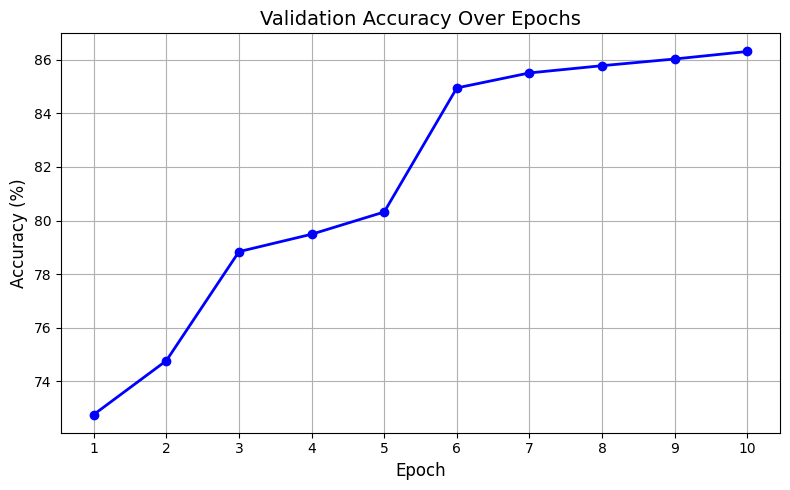

In [ ]:
import matplotlib.pyplot as plt

val_accuracies = [72.76, 74.77, 78.84, 79.49, 80.32, 84.95, 85.51, 85.78, 86.03, 86.31]
epochs = list(range(1, 11))

plt.figure(figsize=(8, 5))
plt.plot(epochs, val_accuracies, marker='o', color='blue', linewidth=2)
plt.title('Validation Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_topk(model, dataloader, topk=(1, 5)):
    model.eval()
    correct = [0] * len(topk)
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = outputs.topk(max(topk), dim=1, largest=True, sorted=True)
            total += labels.size(0)
            for i, k in enumerate(topk):
                correct[i] += sum([labels[j] in pred[j, :k] for j in range(labels.size(0))])
    for i, k in enumerate(topk):
        acc = 100 * correct[i] / total
        print(f"Top-{k} Accuracy: {acc:.2f}%")

evaluate_topk(model, test_loader, topk=(1, 5))

Top-1 Accuracy: 86.31%
Top-5 Accuracy: 97.31%


In [ ]:
from sklearn.metrics import classification_report

# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Load class names
class_names = sorted({x.split('/')[0] for x in train_files})

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
print(report)

                         precision    recall  f1-score   support

              apple_pie      0.726     0.656     0.689       250
         baby_back_ribs      0.857     0.860     0.858       250
                baklava      0.909     0.924     0.917       250
         beef_carpaccio      0.866     0.932     0.898       250
           beef_tartare      0.864     0.816     0.840       250
             beet_salad      0.774     0.836     0.804       250
               beignets      0.899     0.852     0.875       250
               bibimbap      0.958     0.912     0.934       250
          bread_pudding      0.744     0.720     0.732       250
      breakfast_burrito      0.827     0.804     0.815       250
             bruschetta      0.795     0.840     0.817       250
           caesar_salad      0.897     0.908     0.903       250
                cannoli      0.948     0.940     0.944       250
          caprese_salad      0.812     0.932     0.868       250
            carrot_cake 